In [1]:
from edward.models import RandomVariable
from tensorflow.contrib.distributions import Distribution

class CustomRandomVariable(RandomVariable, Distribution):
    def __init__(self):
        super(CustomRandomVariable, self).__init__(*args, **kwargs)
    
    def _log_prob(self, value):
        raise NotImplementedError("log_prob is not implement")
        
    def _sample_n(self, n, seed=None):
        raise NotImplementedError("sample_n is not implemented")

In [5]:
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from edward.models import Normal

def build_toy_dataset(N, noise_std=0.5):
    X = np.concatenate([np.linspace(0, 2, num=N / 2),
                       np.linspace(6, 8, num=N / 2)])
    y = 2.0 * X + 10 * np.random.normal(0, noise_std, size=N)
    X = X.astype(np.float32).reshape((N, 1))
    y = y.astype(np.float32)
    return X, y

ed.set_seed(42)

# Data

In [11]:
N = 40
D = 1

X_train, y_train = build_toy_dataset(N)
X_test, y_test = build_toy_dataset(N)

# Model

In [12]:
X = tf.placeholder(tf.float32, [N, D])
w = Normal(mu=tf.zeros(D), sigma=tf.ones(D))
b = Normal(mu=tf.zeros(1), sigma=tf.ones(1))
y = Normal(mu=ed.dot(X, w), sigma=tf.ones(N))

# Inference

In [13]:
qw = Normal(mu=tf.Variable(tf.random_normal([D])),
           sigma=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
qb = Normal(mu=tf.Variable(tf.random_normal([1])),
           sigma=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

inference = ed.KLqp({w: qw, b: qb}, data={X: X_train, y:y_train})
inference.run()

Iteration    1 [  0%]: Loss = 1199.708
Iteration  100 [ 10%]: Loss = 494.265
Iteration  200 [ 20%]: Loss = 402.805
Iteration  300 [ 30%]: Loss = 416.300
Iteration  400 [ 40%]: Loss = 403.352
Iteration  500 [ 50%]: Loss = 409.581
Iteration  600 [ 60%]: Loss = 402.954
Iteration  700 [ 70%]: Loss = 406.060
Iteration  800 [ 80%]: Loss = 402.992
Iteration  900 [ 90%]: Loss = 404.341
Iteration 1000 [100%]: Loss = 404.799


# Criticism

In [14]:
y_post = ed.copy(y, {w:qw.mean(), b:qb.mean()})

In [15]:
print("Mean squared error on test data")
print(ed.evaluate("mean_squared_error", data={X:X_test, y_post: y_test}))

Mean squared error on test data
23.4611


In [16]:
print("Dispalying prior predictive sample.")

Dispalying prior predictive sample.


In [17]:
n_prior_samples = 10
w_prior = w.sample(n_prior_samples).eval()
b_prior = b.sample(n_prior_samples).eval()

# Show Diaplay

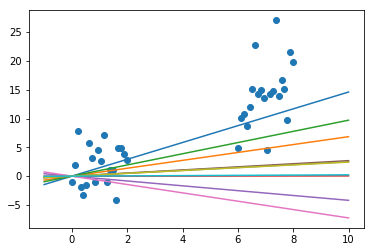

In [24]:
plt.scatter(X_train, y_train)

inputs = np.linspace(-1, 10, num=400, dtype=np.float32)
for ns in range(n_prior_samples):
    output = inputs * w_prior[ns] * b_prior[ns]
    plt.plot(inputs, output)
    
plt.show()

Dispalying posterior predictive sample.
(10, 1)
(10, 1)
(400,)


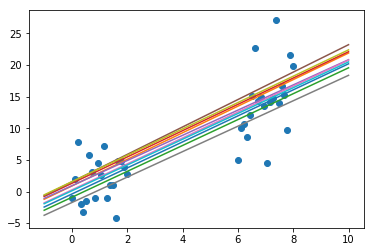

In [32]:
print("Dispalying posterior predictive sample.")
n_posterior_samples = 10

w_post = qw.sample(n_posterior_samples).eval()
b_post = qb.sample(n_posterior_samples).eval()

print(w_post.shape)
print(b_post.shape)
plt.scatter(X_train, y_train)

inputs = np.linspace(-1, 10, num=400, dtype=np.float32)
print(inputs.shape)

for ns in range(n_posterior_samples):
    output = inputs * w_post[ns] + b_post[ns]
    plt.plot(inputs, output)

plt.show()